In [1]:
# imported necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
df = pd.read_csv("../Reviews.csv")
df = df[df['Score'] != 3]
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [3]:
actualScore = df['Score']
positiveNegative = actualScore.map(partition) 
df['Score'] = positiveNegative

In [4]:
sorted_data=df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
(final['Id'].size*1.0)/(df['Id'].size*1.0)*100


69.25890143662969

In [7]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        break;
    i += 1;   

In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
data_pos = final[final["Score"] == "positive"].sample(n = 20000)
data_neg = final[final["Score"] == "negative"].sample(n = 20000)
final = pd.concat([data_pos, data_neg])
final.shape

(40000, 10)

In [10]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    
    final_string.append(str1)
    i+=1

In [11]:
final['CleanedText']=final_string

In [12]:
final["Score"].value_counts()

positive    20000
negative    20000
Name: Score, dtype: int64

In [13]:
def naive_bayes(X_train, y_train):
    
    alpha_values = np.arange(1, 500, 0.5)
        

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha

In [14]:
X = final["CleanedText"]
y = final["Score"]

In [15]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(28000,) (28000,) (12000,)


In [16]:
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<28000x21263 sparse matrix of type '<class 'numpy.int64'>'
	with 898024 stored elements in Compressed Sparse Row format>


The optimal number of alpha is 16.


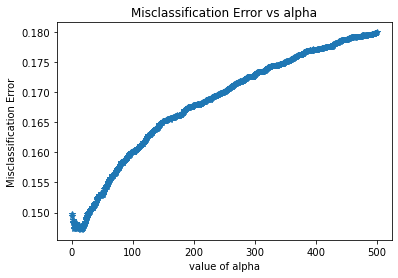

16.0

In [17]:
x_test = bow.transform(x_test)
optimal_alpha_bow = naive_bayes(X_train, y_train)
optimal_alpha_bow

In [18]:
# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = optimal_alpha_bow)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = nb_optimal.predict(x_test)

In [19]:
bow_features = bow.get_feature_names()
feat_count = nb_optimal.feature_count_
feat_count.shape

log_prob = nb_optimal.feature_log_prob_
log_prob

feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

train_acc_bow = nb_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_bow, acc_bow))

Top 10 Negative Features:-
 tast      -4.698229
like      -4.755967
product   -4.870320
one       -5.218591
flavor    -5.270235
would     -5.347426
tri       -5.357827
use       -5.497217
coffe     -5.521002
good      -5.522097
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -4.938743
tast      -4.984101
good      -5.106644
flavor    -5.136152
love      -5.159720
use       -5.189208
great     -5.190241
product   -5.283281
one       -5.290107
tri       -5.374382
Name: 1, dtype: float64
Train accuracy 0.8698214285714285
Train Error 0.130179%

The accuracy of the naive bayes classifier for alpha = 16 is 84.966667%


/Users/federicosuarezpalavecino/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
cm = confusion_matrix(y_test, pred)
cm

array([[5134,  869],
       [ 935, 5062]])

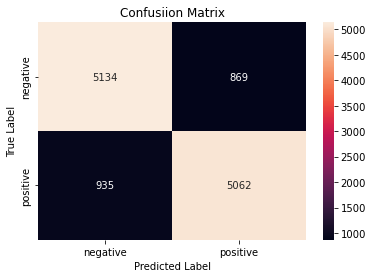

In [21]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [22]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.85      0.86      0.85      6003
    positive       0.85      0.84      0.85      5997

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000

